In [82]:
%matplotlib ipympl

import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as c
from onix.data_tools import get_experiment_data
from onix.units import Q_, ureg

In [140]:
d, h = get_experiment_data(4778139)

In [141]:
sample_rate = h["params"]["digitizer"]["sample_rate"]
fid_params = h["params"]["detect"]["fid"]

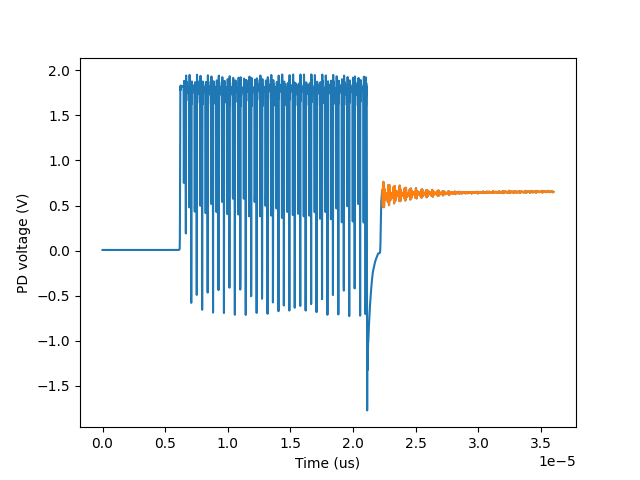

In [142]:
probe_start_time = (4 * ureg.us + 1.2 * ureg.us + fid_params["pump_time"] + fid_params["wait_time"] + h["params"]["ao"]["rise_delay"]).to("s").magnitude
pump_time = fid_params["pump_time"].to("s").magnitude
probe_time = fid_params["probe_time"].to("s").magnitude

fid_avg = d["transmissions_avg"][0]
fid_times = np.arange(len(fid_avg)) / sample_rate
fig, ax = plt.subplots()
ax.set_xlabel("Time (us)")
ax.set_ylabel("PD voltage (V)")
ax.plot(fid_times, fid_avg)
filtered_times = fid_times[fid_times > probe_start_time]
filtered_signals = fid_avg[fid_times > probe_start_time]
ax.plot(filtered_times, filtered_signals)
plt.show()

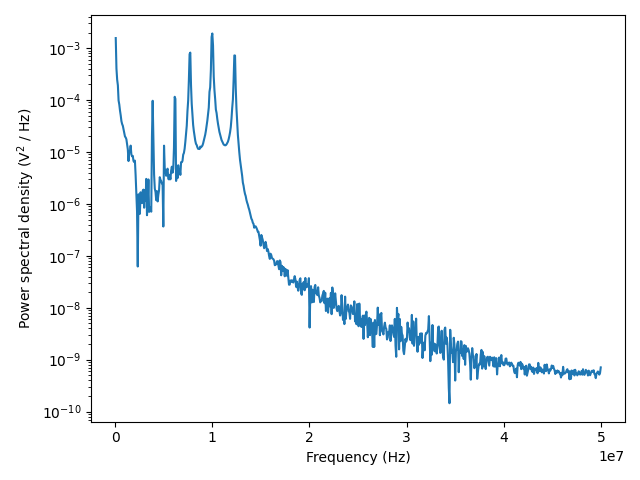

In [143]:
signal_fft = np.fft.rfft(filtered_signals)[1:]
signal_psd = 2 * np.abs(signal_fft) ** 2 / (sample_rate / len(filtered_signals))
fs = np.fft.rfftfreq(len(filtered_times), filtered_times[1] - filtered_times[0])[1:]

fig, ax = plt.subplots()
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("Power spectral density (V$^2$ / Hz)")
ax.set_yscale("log")
#ax.set_xscale("log")
ax.plot(fs, signal_psd)
plt.tight_layout()
plt.show()

In [144]:
w_0 = 100e-6
D = 7e-5

def optical_power_to_avg_Rabi_frequency(P):
    return np.sqrt(2 * P * c.c * c.epsilon_0 / (np.pi * w_0)**2) * D * 76e3


eu_site_1_density_per_cubic_mm = 9.3e14
eu_site_1_number_in_beam = np.pi * (w_0 * 1e3)**2 * 5 * eu_site_1_density_per_cubic_mm
eu_site_1_number_in_beam_per_polarization = eu_site_1_number_in_beam / 2

In [149]:
probe_optical_power = 2e-6  # ASSUMPTION: 2 uW at 220 AOM amplitude
probe_voltage = 0.6
#probe_Rabi_freq = optical_power_to_avg_Rabi_frequency(probe_optical_power)
#probe_pulse_phase = probe_Rabi_freq * probe_time
pump_optical_power_each = probe_optical_power * (1026 / 220) ** 4 / 2
#pump_Rabi_freq = optical_power_to_avg_Rabi_frequency(pump_optical_power_each)
#pump_pulse_phase = pump_Rabi_freq * pump_time
#decay_time = pump_time
#linewidth = 1 / decay_time
geometric_mean_power = np.sqrt(probe_optical_power * pump_optical_power_each)
#eu_number_opt_spec_class = eu_site_1_number_in_beam_per_polarization * linewidth / (700e6 * 2 * np.pi)
OD = 0.1
fid_voltage = geometric_mean_power / probe_optical_power * probe_voltage * OD

In [150]:
fid_voltage

0.92275331156074

In [166]:
QE = 0.5
photon_rate = 2e-6 / (c.h * c.c / (580e-9))
photon_number = photon_rate * probe_time
electron_number = QE * photon_number
electron_fractional_shot_noise_sqrt_psd = np.sqrt(2 * electron_number / (1 / probe_time)) / electron_number
electron_fractional_shot_noise_sqrt_psd_avg = electron_fractional_shot_noise_sqrt_psd / np.sqrt(3000)

In [172]:
fid_voltage_sqrt_psd = fid_voltage / np.sqrt(1 / probe_time)
fid_SNR = fid_voltage_sqrt_psd / (probe_voltage * electron_fractional_shot_noise_sqrt_psd_avg)

In [173]:
fid_SNR

394186.0508434557